<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [809]:
import numpy as np
import pandas as pd

In [810]:
# Исходные данные для моделировния

# Фонтанирующая скважина
# p_R = 28  # Среднепластовое давление
# p_G0 = 25  # Давление насыщенного газа

# Нефонтанирующая скважина
p_R = 21.65  # Среднепластовое давление
p_G0 = 17.32  # Давление насыщенного газа

H_R = 3000  # Глубина забоя по вертикали
w_1 = 12  # Гидропроводность из пласта в ПЗ скважины
w_2 = 60  # Гидропроводность из ПЗ в забой
betta = 0.3  # Объёмная доля воды
p_0 = 0.1  # Атмосферное давление

# Удельный вес
gamma_oil = 0.0068  # нефти
gamma_water = 0.011  # воды
gamma_gas = 0.000008  # газа
G = 100  # Газовый фактор
p_L = 1.5  # Давление в линии нефтесбора

# Гидросопротивление
r_K = 0.5  # обсадной колонный
r_N = 4  # НКТ
r_T = 0.8  # затрубного пространства
r_U = 2  # устьевого штуцера
r_GU = 2  # перепускного клапана

# Параметры насоса
H_N = 2000  # уровень подвеса
q_0 = 60  # номинальный дебит

# Напорная характеристика
q_Pump = [5/3, 4/3, 2/3]
lambda_0 = [10/3, 2, 3/2]
lambda_1 = [2, 1, 1/4]

In [811]:
# Моделируемые данные, начальные условия
_q_N = []
_q_T = []
__q = []
_p_1 = []
_p_2 = []
_p_3 = []
_p_5 = []
_p_4 = []
_p_8 = []
_u = []
_h_4 = []

In [812]:
# Статический расчёт скважины

# Гидросопротивления
r_1 = 1/w_1  # Пласт - ПЗ
r_2 = 1/w_2  # ПЗ - забой
r_R = r_1 + r_2
r_R

0.09999999999999999

In [813]:
# Ограничения
h_lim = 100  # По уровню над приёмом насос
betta_G_lim = 0.25  # По газу у первой ступени

In [814]:
# Высота столба жидкости
gamma = (1-betta)*gamma_oil+betta*gamma_water
dH_R =  (p_R-p_L)/gamma - H_R
dH_R

-500.0

In [815]:
h_0 = q_0*(r_U + r_N + r_K + r_R/gamma) - dH_R

In [816]:
alpha_G_3 = 0.4
alpha_betta = 0.333
k_S = 0.7
X_G = 0.00008

M_R3 = (1-betta)*G*((alpha_G_3*p_0) / (p_G0 - p_0))
p_G3 = p_G0 * (((1-k_S)*M_R3)/(((1-k_S)*M_R3)+alpha_betta))

a_GU = k_S*X_G*M_R3

In [817]:
# Расчёт динамики

# Начальные условия
epsilon = 0.02 * q_0
M_q = 0.5

h_4 = H_N + dH_R
p_2 = p_R
t = 0
w = 1
q = 0
p_3 = p_L + gamma * h_4

# Сегмент напорной характеристики
i = 1

q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
__p_3 = (p_L + p_G0 * r_GU * np.sqrt(w) * a_GU * q + gamma * h_4) / (1 + r_GU * np.sqrt(w) * a_GU * q)
# Балансировка притока по начальным условиям
while abs(p_3 - __p_3) > epsilon:
    p_3 = (1 - M_q)*p_3 + M_q *__p_3
    q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
    __p_3 = (p_L + p_G0 * r_GU * np.sqrt(w) * a_GU * q_0 + gamma * h_4) / (1 + r_GU * np.sqrt(w) * a_GU * q_0)

In [818]:
# Начало расчёта
for k in range(15000):

    p_3 = (p_L + p_G0 * r_GU * np.sqrt(w) * a_GU * q + gamma * h_4) / (1 + r_GU * np.sqrt(w) * a_GU * q)
    q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)


    # Расчёт подачи

    q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
    q_N = max(q_N, 0)

    if w*q_0*q_Pump[0] <= q_N <= w*q_0*q_Pump[1]:
        i = 0
        q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
        q_N = max(q_N, 0)

    if w*q_0*q_Pump[1] < q_N < w*q_0*q_Pump[2]:
        i = 1
        q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
        q_N = max(q_N, 0)

    if w*q_0*q_Pump[1] <= q_N <= w*q_0*q_Pump[2]:
        i = 2
        q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
        q_N = max(q_N, 0)



    betta_G3 = (M_R3*(p_G0 - p_3)) / (p_3 + M_R3*(p_G0 - p_3))
    M_RS = (1 - k_S*np.sqrt(w))* M_R3
    betta_GN = (M_RS*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))

    h_4 = (1/gamma)*(p_3 - p_L - r_GU*np.sqrt(w)*a_GU*(p_G0-p_3)*q)

    p_1 = p_R - r_R*q

    _p_1.append(p_1)
    _p_3.append(p_3)
    _q_N.append(q_N)
    __q.append(q)
    _h_4.append(h_4)
    _u.append(w)

    # Шаг по Эйлеру

    p_2 = p_2 + (0.0001/0.4)*(p_R - p_2 - r_2*q)
    h_4 = h_4 + (0.0001/0.01)*(q-q_N)


In [819]:
x = [0.0001*k for k in range(35000)]

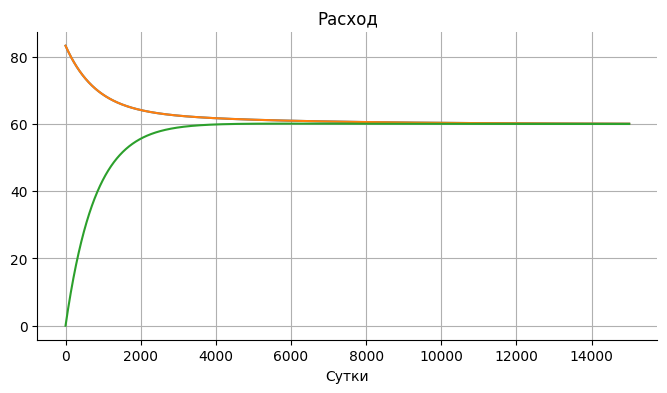

In [820]:
df = pd.DataFrame({'q_N': _q_N, 'p_3': _p_3, 'p_1': _p_1, 'q': __q, 'h_4': _h_4, 'u': _u})

from matplotlib import pyplot as plt
df['q_N'].plot(kind='line', figsize=(8, 4), title='q_N', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

x = np.linspace(0, 3,5, 3499)

# plot one by one
plt.plot(df['q_N'])
plt.plot(df['q'])


# set x label
plt.xlabel('Сутки')

# set title
plt.title('Расход')

# display plot
plt.show()

In [821]:
df['q_N']

,q_N
0,83.297543
1,83.272484
2,83.247455
3,83.222457
4,83.197490
...,...
14995,60.100595
14996,60.100570
14997,60.100544
14998,60.100519


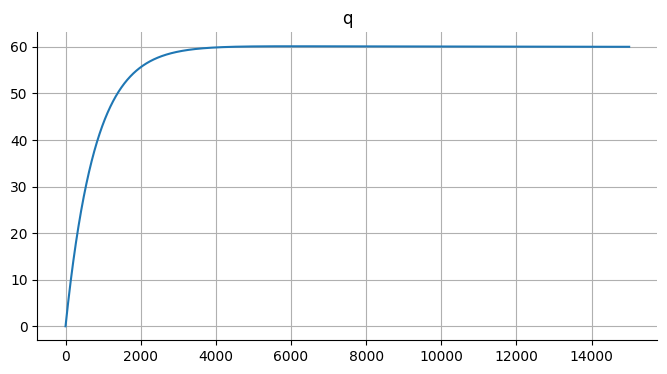

In [822]:
from matplotlib import pyplot as plt
df['q'].plot(kind='line', figsize=(8, 4), title='q', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

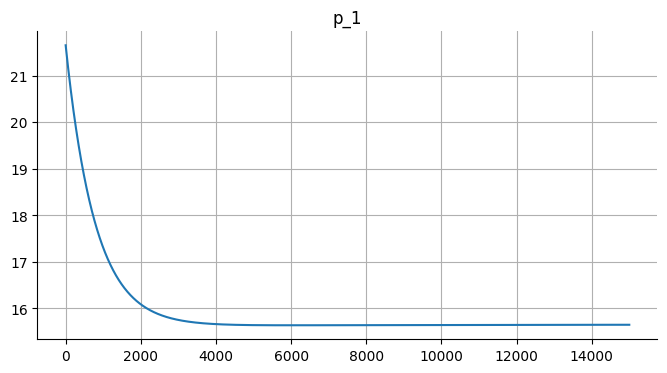

In [823]:
from matplotlib import pyplot as plt
df['p_1'].plot(kind='line', figsize=(8, 4), title='p_1', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

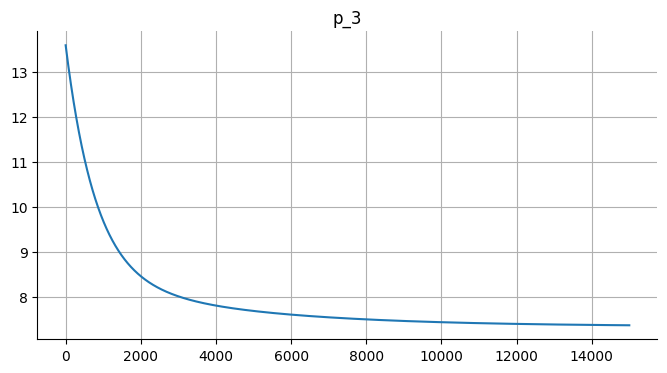

In [824]:
from matplotlib import pyplot as plt
df['p_3'].plot(kind='line', figsize=(8, 4), title='p_3', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

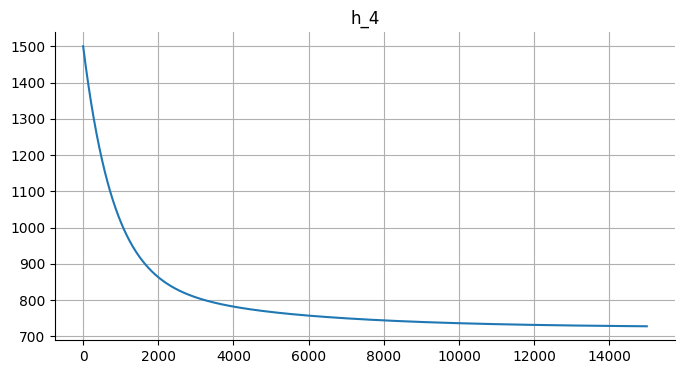

In [825]:
from matplotlib import pyplot as plt
df['h_4'].plot(kind='line', figsize=(8, 4), title='h_4', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

In [826]:
df.iloc[10200]

,10200
q_N,60.337475
p_3,7.438615
p_1,15.644609
q,60.053912
h_4,735.460087
u,1.000000


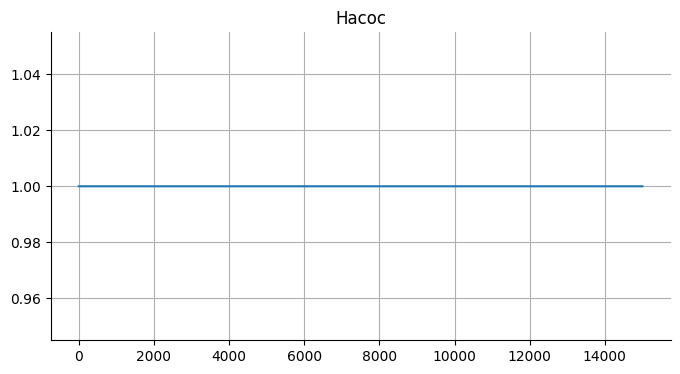

In [827]:
from matplotlib import pyplot as plt
df['u'].plot(kind='line', figsize=(8, 4), title='Насос', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)